<a href="https://colab.research.google.com/github/amirkasaei/Multi-Lable-Text-Classification/blob/main/Multi_Lable_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Constants**

---



## **Hazm**

In [8]:
pip install hazm -q

In [ ]:
!wget https://github.com/sobhe/hazm/releases/download/v0.5/resources-0.5.zip
!unzip resources-0.5.zip -d resources

## **imports**

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, MaxPooling1D, GlobalMaxPool1D, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
# from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import os
import string
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from copy import deepcopy
from __future__ import unicode_literals
import hazm

In [ ]:
# PerSick dataset
!gdown --id 1f9eeHpkoyKmTsuZeNkXHrZK-4TP3BtOP
# subject classification dataset
!gdown --id 1ja5_brqB4kFhcjSCT_DhGqOmeEPfqGPc
# dataset with subject and score classes (main for RNN)
!gdown --id 1UJMcB24gRzj6-uyNR6y33Vv1R8QdvzTX

# **Helper functions**

In [ ]:
def encode6ClassToOneHot(arr):
  tmp = np.zeros((arr.shape[0], 6))
  tmp[np.where(arr==1)[0], :] = [1, 0, 0, 0, 0, 0]
  tmp[np.where(arr==2)[0], :] = [0, 1, 0, 0, 0, 0]
  tmp[np.where(arr==3)[0], :] = [0, 0, 1, 0, 0, 0]
  tmp[np.where(arr==4)[0], :] = [0, 0, 0, 1, 0, 0]
  tmp[np.where(arr==5)[0], :] = [0, 0, 0, 0, 1, 0]
  tmp[np.where(arr==6)[0], :] = [0, 0, 0, 0, 0, 1]
  return tmp

def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

def convertOneHotToClassNumber(arr):
  tmp = np.zeros((arr.shape[0], 1))
  tmp[np.arange(len(arr)), 0] = arr.argmax(1) + 1
  return tmp

In [ ]:
# create correct input form for SC NN
def encodeSubjects(subjects):
  subjects_encoded = []
  for subject in subjects:
    subjects_encoded.append(encodeWord(subject))

  subjects_encoded = np.array(subjects_encoded)

  subjects_encoded_pad = pad_sequences(subjects_encoded, maxlen=max_len, padding='post')
  subjects_encoded_OH = to_categorical(subjects_encoded_pad, num_classes=len(char_index))
  return subjects_encoded_OH

In [ ]:
def showPlots(model):
    plt.plot(model.history['accuracy'],
              label='training accuracy', marker='.', color='green')
    plt.plot(model.history['val_accuracy'],
              label='test accuracy', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(model.history['loss'],
              label='training loss', marker='.', color='green')
    plt.plot(model.history['val_loss'],
              label='test loss', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# **Subject Classsification NN (RNN)**



## **Preprocessing**

In [26]:
# read subject classification dataset
scdataset = pd.read_excel('/content/subject classification dataset.xlsx')

# replace nan values with 'NA'
scdataset = scdataset.replace(to_replace = np.nan, value = 'NA')

In [27]:
# data augmentation

classes = scdataset['Class']
class1_indices = np.where(classes == 1)
class2_indices = np.where(classes == 2)
class3_indices = np.where(classes == 3)

dataset_words = scdataset['Word'].values.tolist()

def augmentData(dataset_words, class_indices, class_num):
  type1 = [[dataset_words[i] + 'ی', class_num] for i in class_indices[0]]
  type2 = [[dataset_words[i] + 'ها', class_num] for i in class_indices[0]]
  type3 = [[dataset_words[i] + 'ان', class_num] for i in class_indices[0]]
  return type1 + type2 + type3

words = np.array(augmentData(dataset_words, class1_indices, 1) + augmentData(dataset_words, class2_indices, 2) + augmentData(dataset_words, class3_indices, 3))

dataAug = pd.DataFrame(words, columns=['Word', 'Class'])

scdataset_aug = pd.concat([scdataset, dataAug], axis=0, ignore_index=True)
scdataset_aug.head()

,Word,Class
0,خرس,4
1,گاو میش,4
2,کروکدیل,4
3,گوزن,4
4,شاهین,4


In [ ]:
X_train_sc = np.array(scdataset['Word'])
y_train_sc = np.array(scdataset['Class'])

# one hot encoding for y_true
y_train_sc = encode6ClassToOneHot(y_train_sc)

print(X_train_sc.shape)
print(y_train_sc.shape)

(465,)
(465, 6)


In [ ]:
# generate character encoding
puncs = list(string.punctuation) + [' ', '1', '\xa0', 'ِ', '\u200c', 'ُ', 'َ', '٫', 'ّ', 'ْ', '۰', '۳', '٫']
oov_token = 'not available char'
char_index = {oov_token: 0}

# encode input with encoding character set
for i in range(len(X_train_sc)):
    chars = list(X_train_sc[i])
    for c in chars:
        if c not in char_index and c not in puncs:
            char_index[c] = len(char_index)

len(char_index)
print(char_index)

{'not available char': 0, 'خ': 1, 'ر': 2, 'س': 3, 'گ': 4, 'ا': 5, 'و': 6, 'م': 7, 'ی': 8, 'ش': 9, 'ک': 10, 'د': 11, 'ل': 12, 'ز': 13, 'ن': 14, 'ه': 15, 'آ': 16, 'ق': 17, 'ب': 18, 'ف': 19, 'ص': 20, 'غ': 21, 'ج': 22, 'ع': 23, 'ت': 24, 'چ': 25, 'پ': 26, 'ح': 27, 'ئ': 28, 'ط': 29, 'ذ': 30, 'ض': 31, 'N': 32, 'A': 33, 'ث': 34, 'ظ': 35, 'ژ': 36}


In [ ]:
# encode words with character encoder
def encodeWord(word, dic=char_index, oov=oov_token):
    return [dic[c] if c in dic else dic[oov] for c in list(word)]

X_train_sc_encoded = np.array([encodeWord(each) for each in X_train_sc])
max_len = max([len(each) for each in X_train_sc_encoded])

print('input shape: ', X_train_sc_encoded.shape)
print('max length in input elements: ', max_len)

input shape:  (465,)
max length in input elements:  11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [ ]:
# ADD padding to sample
X_train_sc_pad = pad_sequences(X_train_sc_encoded, maxlen=max_len, padding='post')

# convert to One Hot encoding
X_train_sc_OH = to_categorical(X_train_sc_pad, num_classes=len(char_index))

X_train_sc_OH.shape

(465, 11, 37)

## **Implementation**

In [ ]:
class SubjectClassificationNN:
  def __init__(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train

    input = Input(shape=X_train.shape[1:])
    x = LSTM(128, return_sequences=True)(input)
    x = GRU(128, return_sequences=True)(x)

    flatten = Flatten()(x)

    out = Dense(256, activation="tanh")(flatten)
    out = Dense(64, activation="tanh")(out)
    out = Dense(6, activation="softmax")(out)

    # Compile the Model
    self.model = Model(inputs=input, outputs=out)
    self.model.compile(loss='mean_squared_error', optimizer=Adam(0.001), metrics=['accuracy'])
    # self.model.summary()


  def train(self):
    filepath = 'my_best_model.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='accuracy',
                              verbose=0,
                              save_best_only=True,
                              mode='max')

    self.history = self.model.fit(self.X_train, self.y_train, epochs=1000, batch_size=64, verbose=0, callbacks=[checkpoint]).history

    self.model = load_model(filepath)

  def getModelResult(self):
    return self.model.evaluate(self.X_train, self.y_train)

  def predictClass(self, subjects):
    encoded_subjects = encodeSubjects(subjects) # encodes input
    pred = self.model.predict(encoded_subjects) # calculate probablity
    pred_OH = argmaxKeepDimensions(pred)  # One hot classification
    pred_class = convertOneHotToClassNumber(pred_OH)  # class number
    return pred_class


# **Preprocessing**

---



## **Generate Dataset**

In [3]:
path = 'https://raw.githubusercontent.com/Ledengary/COPER/main/Datasets/PerSICK.csv'
# read csv data from github
dataset = pd.read_csv(path)
# save dataset file
dataset.to_excel('raw_dataset.xlsx')
# delete rows with nan elements
dataset = dataset.dropna()

In [14]:
dataset.head()

,score,sentence1,sentence2
0,4.5,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,گروهی از پسران در حیاط بازی می کنند و مردی در ...
1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...
2,4.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,بچه ها در بیرون از خانه و در کنار یک مرد با لب...
3,3.4,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...
4,3.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...


In [5]:
inputs = np.array(dataset[['sentence1', 'sentence2']])
scores = np.array(dataset['score'])
print(inputs.shape)
print(scores.shape)

(3101, 2)
(3101,)


In [ ]:
# hazm objects
normalizer = hazm.Normalizer()
lemmatizer = hazm.Lemmatizer()
stemmer = hazm.Stemmer()
tagger = hazm.POSTagger(model='/content/resources/postagger.model')
parser = hazm.DependencyParser(tagger = tagger, lemmatizer = lemmatizer)

In [ ]:
# normalzing data
for i in range(len(inputs)):
  inputs[i] = [normalizer.normalize(inputs[i][0]), normalizer.normalize(inputs[i][1])]

In [ ]:
def findSubject(input):
  tokens = hazm.word_tokenize(input)
  parseGraph = parser.parse(tokens)
  # subjects of each sentence
  subjects = []
  for i in range(len(tokens)):
    tokenDetails = parseGraph.get_by_address(i)
    if tokenDetails['rel'] == 'SBJ':
      subjects.append(tokenDetails['word'])
  return subjects

def findSubjects(input):
  for i in range(len(input)):
    print(i, end=', ', )
    subjects1Col.append(','.join([str(elem) for elem in findSubject(input[i][0])]))
    subjects2Col.append(','.join([str(elem) for elem in findSubject(input[i][1])]))

In [ ]:
subjects1Col = []
subjects2Col = []
with tf.device('/GPU:0'):
  findSubjects(inputs)

dftest = pd.DataFrame(scores, columns=['score'])
dftest['Sentence1'] = inputs[:, 0]
dftest['Subject1'] = subjects1Col
dftest['Sentence2'] = inputs[:, 1]
dftest['Subject2'] = subjects2Col
dftest.style
dftest.to_excel("dataset6.xlsx", sheet_name='Sheet_name_1')

## **Load Generated Dataset**

In [15]:
dataset = pd.read_excel('/content/dataset.xlsx')

In [16]:
dataset = dataset.replace(to_replace = np.nan, value = 'NA')

In [ ]:
# drop rows with unacceptable scores
for j in range(len(dataset)):
  try:
      dataset['score'][j] = float(dataset['score'][j])
  except (TypeError, ValueError):
      dataset.drop(j, axis=0, inplace=True)


In [20]:
dataset.head()

,Unnamed: 0,score,Sentence1,Subject1,Sentence2,Subject2
0,0,4.5,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",گروهی از پسران در حیاط بازی می‌کنند و مردی در ...,"گروهی,مردی,زمینه"
1,1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,"گروهی,مردی",گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی"
2,2,4.7,پسران جوان در فضای باز بازی می‌کنند و مرد در ه...,"پسران,مرد",بچه‌ها در بیرون از خانه و در کنار یک مرد با لب...,بچه‌ها
3,3,3.4,بچه‌ها در بیرون از خانه و در کنار یک مرد با لب...,بچه‌ها,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی"
4,4,3.7,پسران جوان در فضای باز بازی می‌کنند و مرد در ه...,"پسران,مرد",گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی"


In [21]:
sub1 = np.array(dataset['Subject1'])
sub2 = np.array(dataset['Subject2'])
score = np.array(dataset['score'])

In [ ]:
# NN for subject classification
with tf.device('/GPU:0'):
  scnn = SubjectClassificationNN(X_train_sc_OH, y_train_sc)
  scnn.train()
  scnn.getModelResult()

In [ ]:
# Subject Classification for samples

subClass = []

with tf.device('/GPU:0'):
  for i in range(len(sub1)):
    sub1_classes = scnn.predictClass(sub1[i].split(','))
    sub2_classes = scnn.predictClass(sub2[i].split(','))

    commonClasses = np.intersect1d(sub1_classes, sub2_classes)
    if commonClasses.size:
      subClass.append(commonClasses[0]) # append common class number between subjects
    else:
      subClass.append(6)  # append NA class(6) for non-uniform subjects

subClass = np.array(subClass, dtype='int32')

In [ ]:
# Score Classification
print('class 1: ', np.count_nonzero(score < 2.6))
print('class 2: ', np.count_nonzero(score < 3.4) - np.count_nonzero(score < 2.6))
print('class 3: ', np.count_nonzero(score < 4) - np.count_nonzero(score < 3.4))
print('class 4: ', np.count_nonzero(score < 4.5) - np.count_nonzero(score < 4))
print('class 5: ', np.count_nonzero(score <= 5) - np.count_nonzero(score < 4.5))

scoreClass = []

for x in score:
  if x < 2.6:
    scoreClass.append(1)
  elif x < 3.4:
    scoreClass.append(2)
  elif x < 4:
    scoreClass.append(3)
  elif x < 4.5:
    scoreClass.append(4)
  elif x <= 5:
    scoreClass.append(5)

scoreClass = np.array(scoreClass)

print('subject classes shape: ', subClass.shape)
print('score classes shape: ', scoreClass.shape)

class 1:  434
class 2:  664
class 3:  787
class 4:  550
class 5:  662
score classes shape:  3097


In [23]:
dataset = pd.read_excel('/content/datasetwithclasses.xlsx')

In [25]:
# save subject classes into dataframe and save dataframe
dataset['subject classes'] = subClass
dataset['score classes'] = scoreClass

dataset.to_excel("datasetwithclasses.xlsx")
dataset.head()

,Unnamed: 0,score,Sentence1,Subject1,Sentence2,Subject2,subject classes,score classes
0,0,4.5,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",گروهی از پسران در حیاط بازی می‌کنند و مردی در ...,"گروهی,مردی,زمینه",1,5
1,1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,"گروهی,مردی",گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",1,2
2,2,4.7,پسران جوان در فضای باز بازی می‌کنند و مرد در ه...,"پسران,مرد",بچه‌ها در بیرون از خانه و در کنار یک مرد با لب...,بچه‌ها,6,5
3,3,3.4,بچه‌ها در بیرون از خانه و در کنار یک مرد با لب...,بچه‌ها,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",6,3
4,4,3.7,پسران جوان در فضای باز بازی می‌کنند و مرد در ه...,"پسران,مرد",گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",1,3


## **Preprocessing Generated Classification Dataset**

### **Dataset**

In [ ]:
dataset = pd.read_excel('/content/datasetwithclasses.xlsx')

In [ ]:
dataset.head()

,Unnamed: 0,score,Sentence1,Subject1,Sentence2,Subject2,subject classes,score classes
0,0,4.5,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",گروهی از پسران در حیاط بازی می‌کنند و مردی در ...,"گروهی,مردی,زمینه",1,5
1,1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,"گروهی,مردی",گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",1,2
2,2,4.7,پسران جوان در فضای باز بازی می‌کنند و مرد در ه...,"پسران,مرد",بچه‌ها در بیرون از خانه و در کنار یک مرد با لب...,بچه‌ها,6,5
3,3,3.4,بچه‌ها در بیرون از خانه و در کنار یک مرد با لب...,بچه‌ها,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",6,3
4,4,3.7,پسران جوان در فضای باز بازی می‌کنند و مرد در ه...,"پسران,مرد",گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمردی...,"گروهی,پیرمردی",1,3


In [ ]:
subClasses = np.array(dataset['subject classes'])
scoreClasses = np.array(dataset['score classes'])

print("Subject Class Men/Boy: ", np.count_nonzero(subClasses == 1))
print("Subject Class Women/Girl: ", np.count_nonzero(subClasses == 2))
print("Subject Class Child: ", np.count_nonzero(subClasses == 3))
print("Subject Class Animal: ", np.count_nonzero(subClasses == 4))
print("Subject Class Other: ", np.count_nonzero(subClasses == 5))
print("Subject Class NA: ", np.count_nonzero(subClasses == 6))
scoreClasses.shape
#dataset.style

Subject Class Men/Boy:  669
Subject Class Women/Girl:  390
Subject Class Child:  99
Subject Class Animal:  424
Subject Class Other:  568
Subject Class NA:  947


(3097,)

### **Create Y_true**

In [ ]:
subClasses_OH = to_categorical(subClasses, num_classes=7)[:, 1:]
scoreClasses_OH = to_categorical(scoreClasses, num_classes=6)[:, 1:]

print(scoreClasses_OH.shape)
print(subClasses_OH.shape)

(3097, 5)
(3097, 6)


In [ ]:
# Peparing Y true
y = np.concatenate((subClasses_OH, scoreClasses_OH), axis=1)
y.shape

(3097, 11)

### **Create X**

In [ ]:
# Preparing X
sentence1 = np.array(dataset['Sentence1'])
sentence2 = np.array(dataset['Sentence2'])

In [ ]:
# Keras Tokenizer
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
num_words = 1000

sentenceTokenizer = Tokenizer(num_words=num_words, filters=filters, split=' ', oov_token='UNK')

# train on sentences
sentenceTokenizer.fit_on_texts(sentence1)
# sentenceTokenizer.fit_on_texts(sentence2)

# encode sentences
sentence1_encoded = sentenceTokenizer.texts_to_sequences(sentence1)
sentence2_encoded = sentenceTokenizer.texts_to_sequences(sentence2)

In [ ]:
# max number of words in a sentence
max_words_num = max(max([len(x) for x in sentence1_encoded]), max([len(x) for x in sentence2_encoded]))
max_words_num

26

In [ ]:
# normalize sentence lenght with padding
maxlen = 20
sentence1_pad = pad_sequences(sentence1_encoded, maxlen=maxlen, padding='post')
sentence2_pad = pad_sequences(sentence2_encoded, maxlen=maxlen, padding='post')
sentence1_pad.shape, sentence2_pad.shape

((3097, 20), (3097, 20))

In [ ]:
# change input to One Hot
sentence1_OH = to_categorical(sentence1_pad, num_classes=num_words)
sentence2_OH = to_categorical(sentence2_pad, num_classes=num_words)
sentence1_OH.shape, sentence2_OH.shape

((3097, 20, 1000), (3097, 20, 1000))

In [ ]:
# concatenate two sentences
sentences_OH = np.concatenate((sentence1_OH, sentence2_OH), axis=1)
sentences_OH.shape

(3097, 40, 1000)

### **Split data**

In [ ]:
X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(sentence1_OH, sentence2_OH, y, test_size=0.2)
X_train_1.shape, X_train_2.shape, y_train.shape

((2477, 20, 1000), (2477, 20, 1000), (2477, 11))

In [ ]:
X_train_list = [X_train_1, X_train_2]
X_test_list = [X_test_1, X_test_2]

# **Implementation**

---



In [ ]:
class RNN:
  def __init__(self, X_train, y_train, model_num):
    self.X_train = X_train
    self.y_train = y_train

    input1 = Input(shape=np.array(X_train[0]).shape[1:])
    input2 = Input(shape=np.array(X_train[1]).shape[1:])

    if model_num == 1:
      m = self.LSTM_model_1(input1, input2)
    elif model_num == 2:
      m = self.LSTM_model_2(input1, input2)
    elif model_num == 3:
      m = self.LSTM_model_3(input1, input2)
    elif model_num == 4:
      m = self.GRU_model_1(input1, input2)
    elif model_num == 5:
      m = self.GRU_model_2(input1, input2)
    elif model_num == 6:
      m = self.SimpleRNN_model_1(input1, input2)
    elif model_num == 7:
      m = self.SimpleRNN_model_2(input1, input2)
    elif model_num == 8:
      m = self.LSTM_model_4(input1, input2)

    output = Dense(11, activation="sigmoid")(m)

    # Compile the Model
    self.model = Model(inputs=[input1, input2], outputs=output)
    self.model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy'])

    # self.model.summary()

  def LSTM_model_1(self, input1, input2):
    x1 = LSTM(128, return_sequences=True)(input1)
    x1 = LSTM(128)(x1)

    x2 = LSTM(128, return_sequences=True)(input2)
    x2 = LSTM(128)(x2)

    c = Concatenate(axis=1)([x1, x2])

    d = Dense(64, activation='relu')(c)
    d = Dense(32, activation='relu')(d)
    d = Dense(16, activation='relu')(d)

    return d

  def LSTM_model_2(self, input1, input2):
    x1 = LSTM(128, return_sequences=True)(input1)
    x1 = LSTM(128, return_sequences=True)(x1)
    c1 = GlobalMaxPooling1D()(x1)

    x2 = LSTM(128, return_sequences=True)(input2)
    x2 = LSTM(128, return_sequences=True)(x2)
    c2 = GlobalMaxPooling1D()(x2)

    c = Concatenate(axis=1)([c1, c2])

    d = Dense(64, activation='relu')(c)
    d = Dense(32, activation='relu')(d)
    d = Dense(16, activation='relu')(d)

    return d


  def LSTM_model_3(self, input1, input2):
    x1 = LSTM(128, return_sequences=True)(input1)
    x1 = GRU(128)(x1)

    x2 = LSTM(128, return_sequences=True)(input2)
    x2 = GRU(128)(x2)

    c = Concatenate(axis=1)([x1, x2])

    d = Dense(64, activation='relu')(c)
    d = Dense(32, activation='relu')(d)
    d = Dense(16, activation='relu')(d)

    return d

  def LSTM_model_4(self, input1, input2):
    x1 = LSTM(128, return_sequences=True)(input1)
    x1 = SimpleRNN(128, return_sequences=True)(x1)
    x1 = SimpleRNN(128, return_sequences=True)(x1)
    c1 = GlobalMaxPooling1D()(x1)

    x2 = LSTM(128, return_sequences=True)(input2)
    x2 = SimpleRNN(128, return_sequences=True)(x2)
    x2 = SimpleRNN(128, return_sequences=True)(x2)
    c2 = GlobalMaxPooling1D()(x2)

    c = Concatenate(axis=1)([c1, c2])

    d = Dense(64, activation='relu')(c)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu')(d)
    d = Dropout(0.1)(d)
    d = Dense(16, activation='relu')(d)

    return d

  def GRU_model_1(self, input1, input2):
    x1 = GRU(128, return_sequences=True)(input1)
    x1 = GRU(128)(x1)

    x2 = GRU(128, return_sequences=True)(input2)
    x2 = GRU(128)(x2)

    c = Concatenate(axis=1)([x1, x2])

    d = Dense(64, activation='relu')(c)
    d = Dense(32, activation='relu')(d)
    d = Dense(16, activation='relu')(d)

    return d

  def GRU_model_2(self, input1, input2):
    x1 = GRU(256, return_sequences=True)(input1)
    c1 = GlobalMaxPooling1D()(x1)

    x2 = GRU(256, return_sequences=True)(input2)
    c2 = GlobalMaxPooling1D()(x2)

    c = Concatenate(axis=1)([c1, c2])

    d = Dense(64, activation='relu')(c)
    d = Dense(32, activation='relu')(d)
    d = Dense(16, activation='relu')(d)

    return d

  def SimpleRNN_model_1(self, input1, input2):
    x1 = SimpleRNN(128, return_sequences=True)(input1)
    x1 = SimpleRNN(128)(x1)

    x2 = SimpleRNN(128, return_sequences=True)(input2)
    x2 = SimpleRNN(128)(x2)

    c = Concatenate(axis=1)([x1, x2])

    d = Dense(64, activation='relu')(c)
    # d = Dense(64, activation='relu')(d)
    d = Dense(16, activation='relu')(d)

    return d

  def SimpleRNN_model_2(self, input1, input2):
    x1 = SimpleRNN(128, return_sequences=True)(input1)
    x1 = SimpleRNN(128, return_sequences=True)(x1)
    c1 = GlobalMaxPooling1D()(x1)

    x2 = SimpleRNN(128, return_sequences=True)(input2)
    x2 = SimpleRNN(128, return_sequences=True)(x2)
    c2 = GlobalMaxPooling1D()(x2)

    c = Concatenate(axis=1)([c1, c2])

    d = Dense(64, activation='relu')(c)
    d = Dense(32, activation='relu')(d)
    d = Dense(16, activation='relu')(d)

    return d


  def train(self, validation_data):
    filepath = 'my_best_model.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
    self.history = self.model.fit(self.X_train, self.y_train, validation_data=validation_data, epochs=50, batch_size=32, verbose=2, callbacks=[checkpoint]).history
    self.model = load_model(filepath)

  def predict(self):
    self.y_train_pre = self.model.predict(self.X_train)
    self.y_test_pre = self.model.predict(self.X_test)

  def evaluate(self, X_test, y_test):
    self.X_test = X_test
    self.y_test = y_test
    self.test_result = self.model.evaluate(X_test, y_test, verbose=0)

  def outputResult(self):

    # best models based on acc or loss in tarin set or test set
    trainHistory = list(
        map(lambda x, y: [x, y], self.history['accuracy'], self.history['loss']))
    testHistory = list(
        map(lambda x, y: [x, y], self.history['val_accuracy'], self.history['val_loss']))
    print(
        f"\nbest model based on min training set loss:  acc= {min(trainHistory, key = lambda k: k[1])[0]}  loss= {min(trainHistory, key = lambda k: k[1])[1]}")
    print(
        f"best model based on min test set loss:  acc= {min(testHistory, key = lambda k: k[1])[0]}  loss= {min(testHistory, key = lambda k: k[1])[1]}")
    print(
        f"best model based on max training set accuracy:  acc= {max(trainHistory, key = lambda k: k[0])[0]}  loss= {max(trainHistory, key = lambda k: k[0])[1]}")
    print(
        f"best model based on max test set accuracy:  acc= {max(testHistory, key = lambda k: k[0])[0]}  loss= {max(testHistory, key = lambda k: k[0])[1]}")

    print("\nevaluate dataset with best model based on maximum test set accuracy")
    print("evaluate train set= ", self.model.evaluate(
        self.X_train, self.y_train, verbose=0))
    print("evaluate test set= ", self.test_result)

    y_train_pred = self.model.predict(self.X_train)
    # convert probablities to 0s and 1s
    y_train_pred_score = argmaxKeepDimensions(y_train_pred[:, :6])
    y_train_pred_subject = argmaxKeepDimensions(y_train_pred[:, 6:])
    y_train_pred = np.concatenate((y_train_pred_score, y_train_pred_subject), axis=1)

    y_test_pred = self.model.predict(self.X_test)
    # convert probablities to 0s and 1s
    y_test_pred_score = argmaxKeepDimensions(y_test_pred[:, :6])
    y_test_pred_subject = argmaxKeepDimensions(y_test_pred[:, 6:])
    y_test_pred = np.concatenate((y_test_pred_score, y_test_pred_subject), axis=1)

    # confusion matrix and precision, recall and f1 report
    print('\n', '-'*30, 'metrics for traning set', '-'*30)
    print("confusion matrix: \n", metrics.multilabel_confusion_matrix(self.y_train, y_train_pred))
    print(metrics.classification_report(self.y_train,
          y_train_pred, digits=3, target_names=['Men/Boy', 'Women/Girl', 'Child', 'Animal', 'Other', 'NA', 'Score1', 'Score2', 'Score3', 'Score4', 'Score5']))

    # confusion matrix and precision, recall and f1 report
    print('-'*30, 'metrics for test set', '-'*30)
    print("confusion matrix: \n", metrics.multilabel_confusion_matrix(self.y_test, y_test_pred))
    print(metrics.classification_report(self.y_test,
          y_test_pred, digits=3, target_names=['Men/Boy', 'Women/Girl', 'Child', 'Animal', 'Other', 'NA', 'Score1', 'Score2', 'Score3', 'Score4', 'Score5']))

    # self.model.summary()



# **Simple RNN**

## **Model 1**

In [ ]:
with tf.device('/GPU:0'):
  model6 = RNN(X_train_list, y_train, model_num=6)
  model6.train((X_test_list, y_test))
  model6.evaluate(X_test_list, y_test)
  model6.outputResult()

Epoch 1/50
78/78 - 8s - loss: 0.5841 - accuracy: 0.2406 - val_loss: 0.4446 - val_accuracy: 0.4210 - 8s/epoch - 97ms/step
Epoch 2/50
78/78 - 5s - loss: 0.3835 - accuracy: 0.6258 - val_loss: 0.3554 - val_accuracy: 0.7516 - 5s/epoch - 61ms/step
Epoch 3/50
78/78 - 5s - loss: 0.3189 - accuracy: 0.8119 - val_loss: 0.3318 - val_accuracy: 0.7935 - 5s/epoch - 63ms/step
Epoch 4/50
78/78 - 5s - loss: 0.2793 - accuracy: 0.8708 - val_loss: 0.3359 - val_accuracy: 0.7871 - 5s/epoch - 61ms/step
Epoch 5/50
78/78 - 5s - loss: 0.2572 - accuracy: 0.9027 - val_loss: 0.3296 - val_accuracy: 0.8113 - 5s/epoch - 63ms/step
Epoch 6/50
78/78 - 5s - loss: 0.2362 - accuracy: 0.9241 - val_loss: 0.3319 - val_accuracy: 0.8145 - 5s/epoch - 64ms/step
Epoch 7/50
78/78 - 5s - loss: 0.2225 - accuracy: 0.9273 - val_loss: 0.3393 - val_accuracy: 0.8113 - 5s/epoch - 63ms/step
Epoch 8/50
78/78 - 5s - loss: 0.2011 - accuracy: 0.9475 - val_loss: 0.3637 - val_accuracy: 0.7694 - 5s/epoch - 62ms/step
Epoch 9/50
78/78 - 5s - loss: 0.

## **Model 2**

In [ ]:
with tf.device('/GPU:0'):
  model7 = RNN(X_train_list, y_train, model_num=7)
  model7.train((X_test_list, y_test))
  model7.evaluate(X_test_list, y_test)
  model7.outputResult()

Epoch 1/50
78/78 - 8s - loss: 0.5994 - accuracy: 0.0775 - val_loss: 0.5112 - val_accuracy: 0.0468 - 8s/epoch - 101ms/step
Epoch 2/50
78/78 - 5s - loss: 0.4364 - accuracy: 0.3746 - val_loss: 0.4022 - val_accuracy: 0.6081 - 5s/epoch - 67ms/step
Epoch 3/50
78/78 - 5s - loss: 0.3794 - accuracy: 0.6609 - val_loss: 0.3710 - val_accuracy: 0.6597 - 5s/epoch - 66ms/step
Epoch 4/50
78/78 - 5s - loss: 0.3482 - accuracy: 0.7323 - val_loss: 0.3542 - val_accuracy: 0.6758 - 5s/epoch - 70ms/step
Epoch 5/50
78/78 - 5s - loss: 0.3258 - accuracy: 0.7957 - val_loss: 0.3420 - val_accuracy: 0.7806 - 5s/epoch - 66ms/step
Epoch 6/50
78/78 - 5s - loss: 0.3068 - accuracy: 0.8421 - val_loss: 0.3276 - val_accuracy: 0.8065 - 5s/epoch - 66ms/step
Epoch 7/50
78/78 - 5s - loss: 0.2960 - accuracy: 0.8797 - val_loss: 0.3135 - val_accuracy: 0.8516 - 5s/epoch - 66ms/step
Epoch 8/50
78/78 - 5s - loss: 0.2863 - accuracy: 0.8958 - val_loss: 0.3345 - val_accuracy: 0.7952 - 5s/epoch - 67ms/step
Epoch 9/50
78/78 - 5s - loss: 0

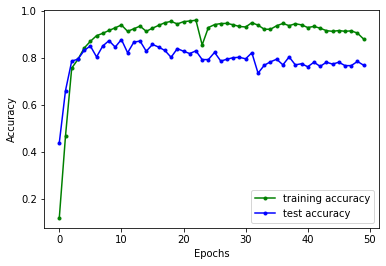

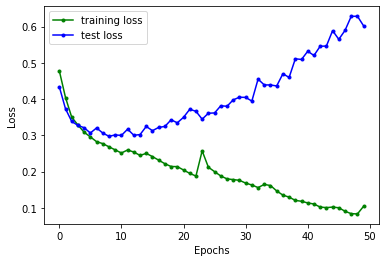

In [ ]:
showPlots(model7)

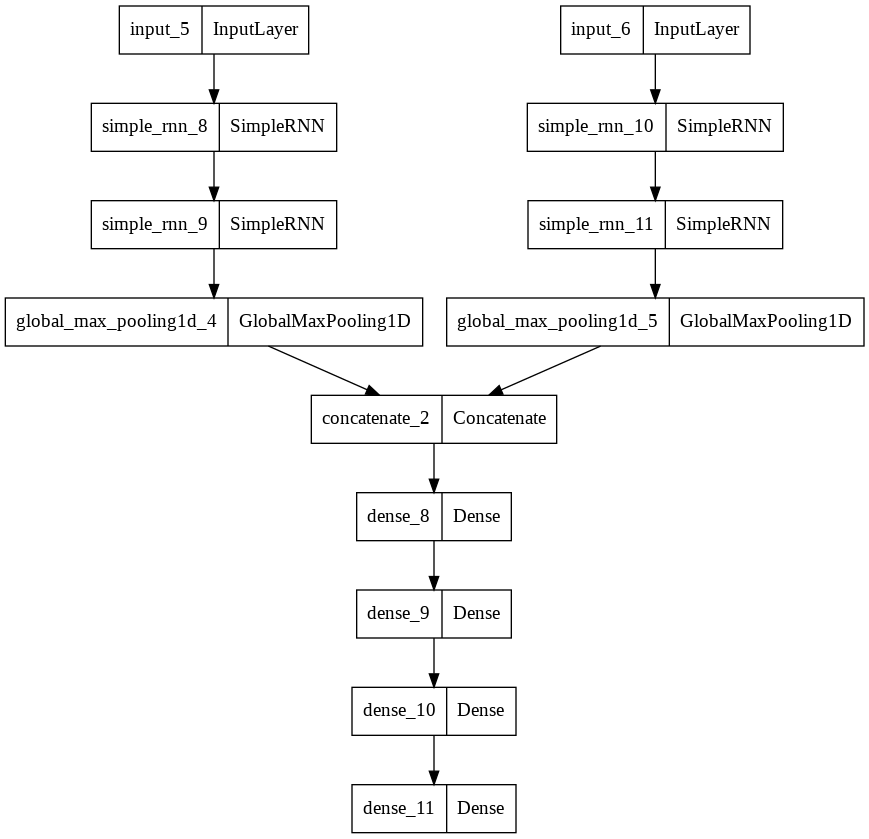

In [ ]:
plot_model(model7.model, to_file='/SimpleRNN_plot.png')

# **GRU Model**

## **Model 1**

In [ ]:
with tf.device('/GPU:0'):
  model4 = RNN(X_train_list, y_train, model_num=4)
  model4.train((X_test_list, y_test))
  model4.evaluate(X_test_list, y_test)
  model4.outputResult()

Epoch 1/50
78/78 - 8s - loss: 0.5300 - accuracy: 0.0287 - val_loss: 0.4705 - val_accuracy: 0.2984 - 8s/epoch - 98ms/step
Epoch 2/50
78/78 - 1s - loss: 0.4590 - accuracy: 0.3076 - val_loss: 0.4565 - val_accuracy: 0.2984 - 1s/epoch - 13ms/step
Epoch 3/50
78/78 - 1s - loss: 0.4567 - accuracy: 0.3076 - val_loss: 0.4561 - val_accuracy: 0.2984 - 1s/epoch - 13ms/step
Epoch 4/50
78/78 - 1s - loss: 0.4555 - accuracy: 0.2604 - val_loss: 0.4548 - val_accuracy: 0.2984 - 1s/epoch - 13ms/step
Epoch 5/50
78/78 - 1s - loss: 0.4398 - accuracy: 0.3096 - val_loss: 0.4254 - val_accuracy: 0.4935 - 1s/epoch - 14ms/step
Epoch 6/50
78/78 - 1s - loss: 0.4071 - accuracy: 0.4546 - val_loss: 0.3909 - val_accuracy: 0.5710 - 1s/epoch - 14ms/step
Epoch 7/50
78/78 - 1s - loss: 0.3730 - accuracy: 0.6193 - val_loss: 0.3564 - val_accuracy: 0.7387 - 1s/epoch - 14ms/step
Epoch 8/50
78/78 - 1s - loss: 0.3386 - accuracy: 0.7626 - val_loss: 0.3445 - val_accuracy: 0.7419 - 1s/epoch - 14ms/step
Epoch 9/50
78/78 - 1s - loss: 0.

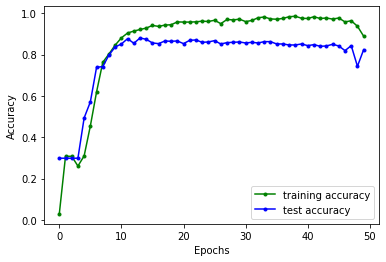

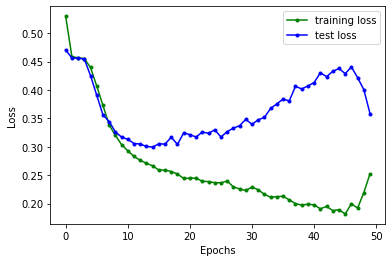

In [ ]:
showPlots(model4)

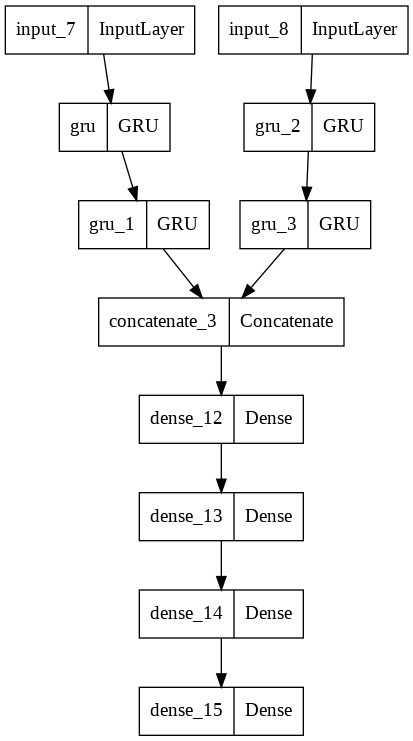

In [ ]:
plot_model(model4.model, to_file='/content/GRU_plot.png')

## **Model 2**

In [ ]:
with tf.device('/GPU:0'):
  model5 = RNN(X_train_list, y_train, model_num=5)
  model5.train((X_test_list, y_test))
  model5.evaluate(X_test_list, y_test)
  model5.outputResult()

Epoch 1/50
78/78 - 4s - loss: 0.5195 - accuracy: 0.0000e+00 - val_loss: 0.4593 - val_accuracy: 0.0000e+00 - 4s/epoch - 55ms/step
Epoch 2/50
78/78 - 1s - loss: 0.4408 - accuracy: 0.2313 - val_loss: 0.4235 - val_accuracy: 0.3871 - 917ms/epoch - 12ms/step
Epoch 3/50
78/78 - 1s - loss: 0.3940 - accuracy: 0.5474 - val_loss: 0.3740 - val_accuracy: 0.5887 - 933ms/epoch - 12ms/step
Epoch 4/50
78/78 - 1s - loss: 0.3524 - accuracy: 0.6770 - val_loss: 0.3502 - val_accuracy: 0.7065 - 906ms/epoch - 12ms/step
Epoch 5/50
78/78 - 1s - loss: 0.3229 - accuracy: 0.7885 - val_loss: 0.3279 - val_accuracy: 0.7903 - 951ms/epoch - 12ms/step
Epoch 6/50
78/78 - 1s - loss: 0.2996 - accuracy: 0.8514 - val_loss: 0.3140 - val_accuracy: 0.8500 - 915ms/epoch - 12ms/step
Epoch 7/50
78/78 - 1s - loss: 0.2801 - accuracy: 0.8966 - val_loss: 0.3106 - val_accuracy: 0.8613 - 1s/epoch - 13ms/step
Epoch 8/50
78/78 - 1s - loss: 0.2660 - accuracy: 0.9237 - val_loss: 0.3196 - val_accuracy: 0.8516 - 822ms/epoch - 11ms/step
Epoch 

# **LSTM Models**

## **Model 1**

In [ ]:
with tf.device('/GPU:0'):
  model1 = RNN(X_train_list, y_train, model_num=1)
  model1.train((X_test_list, y_test))
  model1.evaluate(X_test_list, y_test)
  model1.outputResult()

Epoch 1/50
78/78 - 8s - loss: 0.5292 - accuracy: 0.0852 - val_loss: 0.4390 - val_accuracy: 0.0000e+00 - 8s/epoch - 97ms/step
Epoch 2/50
78/78 - 1s - loss: 0.4179 - accuracy: 0.1332 - val_loss: 0.3869 - val_accuracy: 0.2081 - 1s/epoch - 16ms/step
Epoch 3/50
78/78 - 1s - loss: 0.3855 - accuracy: 0.2939 - val_loss: 0.3667 - val_accuracy: 0.4742 - 1s/epoch - 16ms/step
Epoch 4/50
78/78 - 1s - loss: 0.3490 - accuracy: 0.5591 - val_loss: 0.3452 - val_accuracy: 0.6274 - 1s/epoch - 16ms/step
Epoch 5/50
78/78 - 1s - loss: 0.3351 - accuracy: 0.6455 - val_loss: 0.3426 - val_accuracy: 0.4984 - 1s/epoch - 15ms/step
Epoch 6/50
78/78 - 1s - loss: 0.3318 - accuracy: 0.6395 - val_loss: 0.3283 - val_accuracy: 0.6806 - 1s/epoch - 16ms/step
Epoch 7/50
78/78 - 1s - loss: 0.3107 - accuracy: 0.7505 - val_loss: 0.3181 - val_accuracy: 0.7339 - 1s/epoch - 16ms/step
Epoch 8/50
78/78 - 1s - loss: 0.3069 - accuracy: 0.7671 - val_loss: 0.3174 - val_accuracy: 0.7339 - 1s/epoch - 16ms/step
Epoch 9/50
78/78 - 1s - loss

In [ ]:
with tf.device('/GPU:0'):
  model11 = RNN(X_train_list, y_train, model_num=1)
  model11.train((X_test_list, y_test))
  model11.evaluate(X_test_list, y_test)
  model11.outputResult()

Epoch 1/50
78/78 - 8s - loss: 0.5307 - accuracy: 0.1655 - val_loss: 0.4807 - val_accuracy: 0.1758 - 8s/epoch - 96ms/step
Epoch 2/50
78/78 - 1s - loss: 0.4628 - accuracy: 0.2717 - val_loss: 0.4620 - val_accuracy: 0.2855 - 1s/epoch - 17ms/step
Epoch 3/50
78/78 - 1s - loss: 0.4498 - accuracy: 0.3016 - val_loss: 0.4482 - val_accuracy: 0.3371 - 1s/epoch - 17ms/step
Epoch 4/50
78/78 - 1s - loss: 0.4229 - accuracy: 0.3783 - val_loss: 0.4243 - val_accuracy: 0.3629 - 1s/epoch - 17ms/step
Epoch 5/50
78/78 - 1s - loss: 0.3966 - accuracy: 0.5071 - val_loss: 0.3957 - val_accuracy: 0.5952 - 1s/epoch - 16ms/step
Epoch 6/50
78/78 - 2s - loss: 0.3615 - accuracy: 0.6928 - val_loss: 0.3671 - val_accuracy: 0.6984 - 2s/epoch - 22ms/step
Epoch 7/50
78/78 - 2s - loss: 0.3325 - accuracy: 0.7566 - val_loss: 0.3473 - val_accuracy: 0.7081 - 2s/epoch - 21ms/step
Epoch 8/50
78/78 - 1s - loss: 0.3128 - accuracy: 0.8131 - val_loss: 0.3418 - val_accuracy: 0.7210 - 1s/epoch - 16ms/step
Epoch 9/50
78/78 - 2s - loss: 0.

## **Model 2**

In [ ]:
with tf.device('/GPU:0'):
  model21 = RNN(X_train_list, y_train, model_num=2)
  model21.train((X_test_list, y_test))
  model21.evaluate(X_test_list, y_test)
  model21.outputResult()

Epoch 1/50
78/78 - 8s - loss: 0.6015 - accuracy: 0.0327 - val_loss: 0.5339 - val_accuracy: 0.0371 - 8s/epoch - 104ms/step
Epoch 2/50
78/78 - 1s - loss: 0.4966 - accuracy: 0.1340 - val_loss: 0.4735 - val_accuracy: 0.2065 - 1s/epoch - 17ms/step
Epoch 3/50
78/78 - 1s - loss: 0.4318 - accuracy: 0.3940 - val_loss: 0.4123 - val_accuracy: 0.5419 - 1s/epoch - 16ms/step
Epoch 4/50
78/78 - 1s - loss: 0.3843 - accuracy: 0.6270 - val_loss: 0.3801 - val_accuracy: 0.5339 - 1s/epoch - 16ms/step
Epoch 5/50
78/78 - 2s - loss: 0.3542 - accuracy: 0.6948 - val_loss: 0.3651 - val_accuracy: 0.6452 - 2s/epoch - 29ms/step
Epoch 6/50
78/78 - 1s - loss: 0.3371 - accuracy: 0.7364 - val_loss: 0.3552 - val_accuracy: 0.6629 - 1s/epoch - 19ms/step
Epoch 7/50
78/78 - 1s - loss: 0.3148 - accuracy: 0.8179 - val_loss: 0.3469 - val_accuracy: 0.7597 - 1s/epoch - 17ms/step
Epoch 8/50
78/78 - 1s - loss: 0.2956 - accuracy: 0.8692 - val_loss: 0.3241 - val_accuracy: 0.8097 - 1s/epoch - 16ms/step
Epoch 9/50
78/78 - 1s - loss: 0

## **Model 3**

In [ ]:
with tf.device('/GPU:0'):
  model3 = RNN(X_train_list, y_train, model_num=3)
  model3.train((X_test_list, y_test))
  model3.evaluate(X_test_list, y_test)
  model3.outputResult()

Epoch 1/50
78/78 - 8s - loss: 0.5966 - accuracy: 0.0000e+00 - val_loss: 0.5383 - val_accuracy: 0.0000e+00 - 8s/epoch - 104ms/step
Epoch 2/50
78/78 - 1s - loss: 0.4967 - accuracy: 0.0763 - val_loss: 0.4659 - val_accuracy: 0.1597 - 1s/epoch - 16ms/step
Epoch 3/50
78/78 - 1s - loss: 0.4404 - accuracy: 0.3690 - val_loss: 0.4298 - val_accuracy: 0.4081 - 1s/epoch - 15ms/step
Epoch 4/50
78/78 - 1s - loss: 0.4034 - accuracy: 0.5329 - val_loss: 0.4208 - val_accuracy: 0.5097 - 1s/epoch - 16ms/step
Epoch 5/50
78/78 - 1s - loss: 0.3886 - accuracy: 0.5793 - val_loss: 0.4109 - val_accuracy: 0.4919 - 1s/epoch - 14ms/step
Epoch 6/50
78/78 - 1s - loss: 0.3724 - accuracy: 0.6145 - val_loss: 0.3977 - val_accuracy: 0.5403 - 1s/epoch - 17ms/step
Epoch 7/50
78/78 - 1s - loss: 0.3476 - accuracy: 0.7231 - val_loss: 0.3818 - val_accuracy: 0.6532 - 1s/epoch - 15ms/step
Epoch 8/50
78/78 - 1s - loss: 0.3309 - accuracy: 0.7662 - val_loss: 0.3652 - val_accuracy: 0.6661 - 1s/epoch - 15ms/step
Epoch 9/50
78/78 - 1s -

## **Model 4**

In [ ]:
with tf.device('/GPU:0'):
  model8 = RNN(X_train_list, y_train, model_num=8)
  model8.train((X_test_list, y_test))
  model8.evaluate(X_test_list, y_test)
  model8.outputResult()

Epoch 1/50
78/78 - 18s - loss: 0.5487 - accuracy: 0.1558 - val_loss: 0.4773 - val_accuracy: 0.3468 - 18s/epoch - 233ms/step
Epoch 2/50
78/78 - 5s - loss: 0.4647 - accuracy: 0.2842 - val_loss: 0.4286 - val_accuracy: 0.4774 - 5s/epoch - 69ms/step
Epoch 3/50
78/78 - 5s - loss: 0.4293 - accuracy: 0.4098 - val_loss: 0.3960 - val_accuracy: 0.6065 - 5s/epoch - 68ms/step
Epoch 4/50
78/78 - 5s - loss: 0.3915 - accuracy: 0.5672 - val_loss: 0.3679 - val_accuracy: 0.6419 - 5s/epoch - 70ms/step
Epoch 5/50
78/78 - 5s - loss: 0.3688 - accuracy: 0.6657 - val_loss: 0.3422 - val_accuracy: 0.7290 - 5s/epoch - 70ms/step
Epoch 6/50
78/78 - 5s - loss: 0.3473 - accuracy: 0.7368 - val_loss: 0.3273 - val_accuracy: 0.8048 - 5s/epoch - 69ms/step
Epoch 7/50
78/78 - 5s - loss: 0.3298 - accuracy: 0.7893 - val_loss: 0.3107 - val_accuracy: 0.8500 - 5s/epoch - 69ms/step
Epoch 8/50
78/78 - 5s - loss: 0.3197 - accuracy: 0.8317 - val_loss: 0.3102 - val_accuracy: 0.8484 - 5s/epoch - 68ms/step
Epoch 9/50
78/78 - 5s - loss:

In [ ]:
with tf.device('/GPU:0'):
  model81 = RNN(X_train_list, y_train, model_num=8)
  model81.train((X_test_list, y_test))
  model81.evaluate(X_test_list, y_test)
  model81.outputResult()

Epoch 1/50
78/78 - 12s - loss: 0.5100 - accuracy: 0.0832 - val_loss: 0.4290 - val_accuracy: 0.4258 - 12s/epoch - 152ms/step
Epoch 2/50
78/78 - 6s - loss: 0.4228 - accuracy: 0.4425 - val_loss: 0.3835 - val_accuracy: 0.6065 - 6s/epoch - 71ms/step
Epoch 3/50
78/78 - 6s - loss: 0.3853 - accuracy: 0.6165 - val_loss: 0.3631 - val_accuracy: 0.7210 - 6s/epoch - 71ms/step
Epoch 4/50
78/78 - 6s - loss: 0.3639 - accuracy: 0.7109 - val_loss: 0.3336 - val_accuracy: 0.8274 - 6s/epoch - 71ms/step
Epoch 5/50
78/78 - 5s - loss: 0.3386 - accuracy: 0.8099 - val_loss: 0.3227 - val_accuracy: 0.8274 - 5s/epoch - 69ms/step
Epoch 6/50
78/78 - 6s - loss: 0.3249 - accuracy: 0.8228 - val_loss: 0.3169 - val_accuracy: 0.8306 - 6s/epoch - 71ms/step
Epoch 7/50
78/78 - 6s - loss: 0.3138 - accuracy: 0.8494 - val_loss: 0.3070 - val_accuracy: 0.8548 - 6s/epoch - 71ms/step
Epoch 8/50
78/78 - 6s - loss: 0.3041 - accuracy: 0.8676 - val_loss: 0.3074 - val_accuracy: 0.8500 - 6s/epoch - 78ms/step
Epoch 9/50
78/78 - 5s - loss:

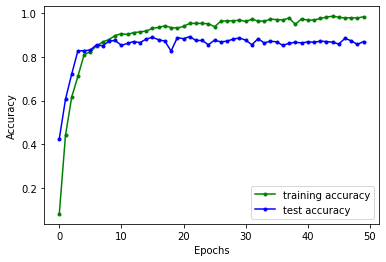

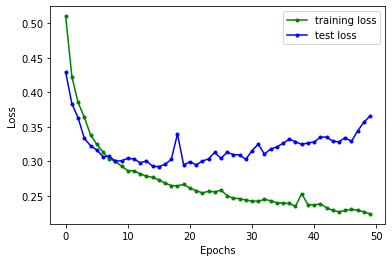

In [ ]:
showPlots(model81)

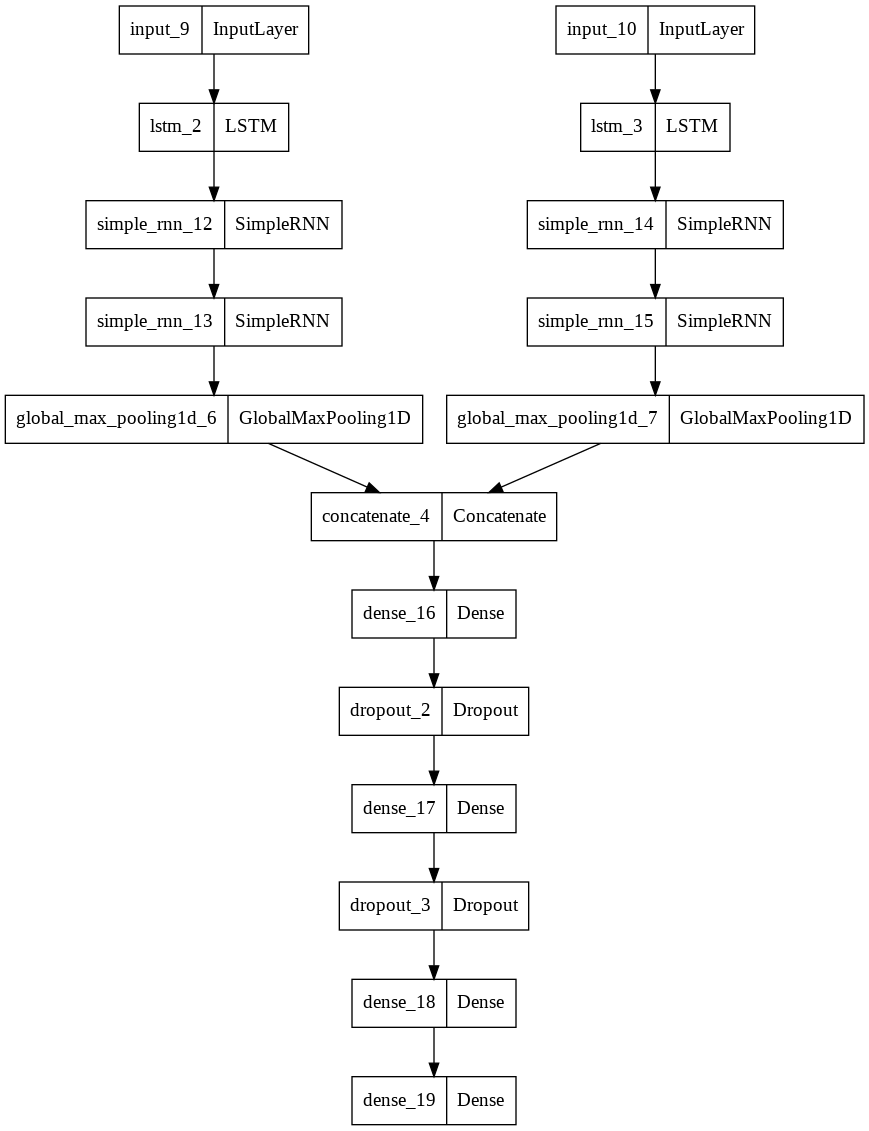

In [ ]:
plot_model(model8.model, to_file='/content/LSTM_plot.png')